# Segmentação de imagens utilizando clusterização k-médias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from sklearn.cluster import KMeans     # Biblioteca de aprendizado de máquina
import skimage.color

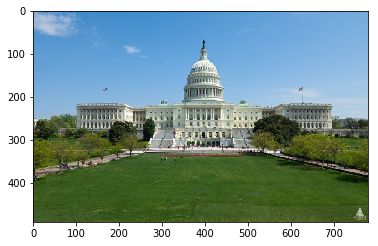

In [2]:
img = plt.imread('capitol.tiff')
plt.imshow(img)

## 1. K-médias no espaço de cor RGB

[[134.14052579 139.44503332 128.51841843]
 [123.8708737  173.7150684  216.52552657]
 [ 61.77569803  83.61119282  33.21127826]]


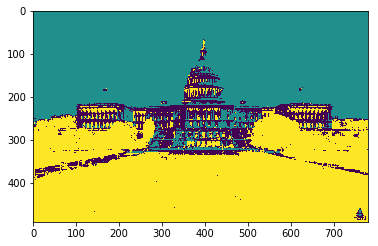

In [3]:
num_clusters = 3

# Redimensiona a imagem, formando um array onde cada linha é um
# pixel e cada coluna é um atributo (cores do pixel)
data = img.reshape(img.shape[0]*img.shape[1], 3)

# Cria instância da classe KMeans e ajusta aos dados
km = KMeans(n_clusters=num_clusters)
km.fit(data)

# Imprime os valores finais obtidos para as sementes
print(km.cluster_centers_)

# Obtém o rótulo de cada pixel. labels é um array 1D de tamanho
# igual ao número de pixels na imagem
labels = km.predict(data)

# Redimensiona o array labels para o mesmo número de linhas
# e colunas do array img
img_labels = labels.reshape(img.shape[:2])

plt.imshow(img_labels)

### Mostrando cada rótulo em uma imagem separada

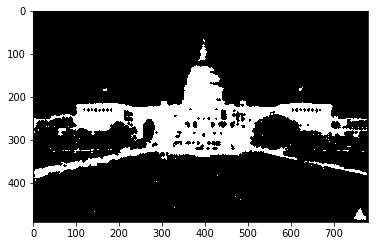

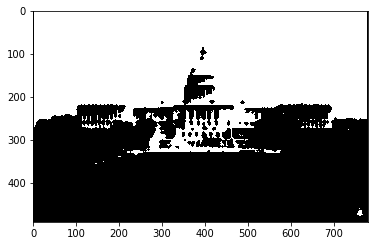

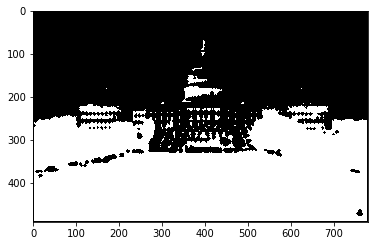

In [4]:
# Primeiro fazemos uma operação de fechamento em cada rótulo identificado, para eliminar alguns buracos
img_labels_closed = np.zeros((num_clusters, img.shape[0], img.shape[1]))
for label in range(num_clusters):
    img_mask = img_labels==label
    img_labels_closed[label] = ndi.binary_closing(img_mask, iterations=3)
    
for label in range(num_clusters):
    plt.figure()
    plt.imshow(img_labels_closed[label], 'gray')

Note que no resultado acima, se obtivermos o maior componente conexo e realizarmos operações adequadas de abertura e fechamento, o resultado será bem razoável.

### Mostrando os rótulos na cor original

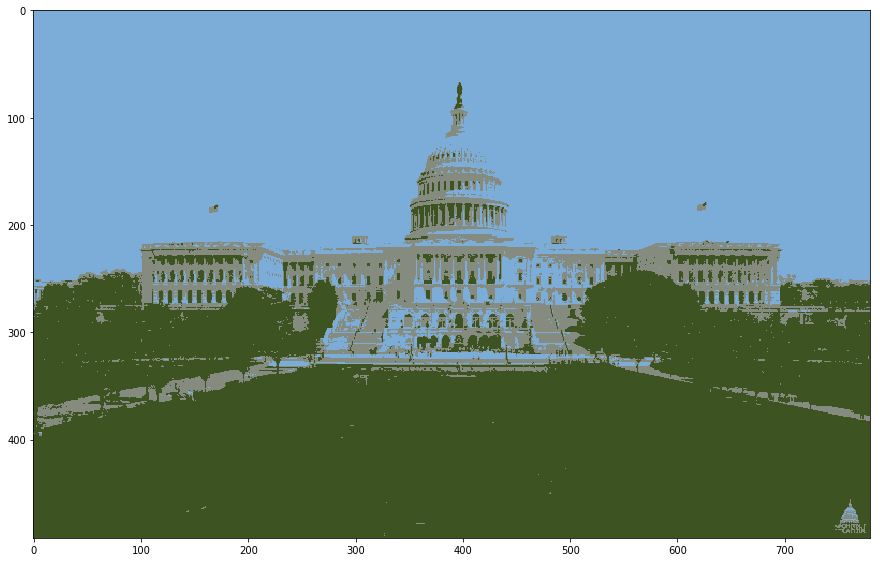

In [5]:
# Para cada canal, substituímos os pixels brancos da imagem segmentada
# pelo valor do centróide do respectivo cluster
img_reconst = np.zeros_like(img)
for label in range(num_clusters):
    img_mask = img_labels==label
    
    # A linha abaixo possui o significado: para cada pixel em
    # img_reconst onde img_mask é True, coloque o valor RGB do 
    # centróide do cluster possuindo índice label
    img_reconst[img_mask] = km.cluster_centers_[label]

plt.figure(figsize=[15,15])
plt.imshow(img_reconst)

## 2. K-médias no espaço de cores L\*a\*b\*

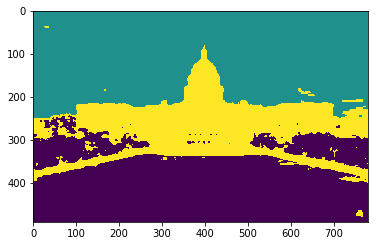

In [6]:
# Transforma espaço de cores de RGB para Lab. Esse espaço
# possui três canais de cores: L, a e b
img_lab = skimage.color.rgb2lab(img)
# O mesmo comando utilizando OpenCV seria
#img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

# Vamos utilizar apenas os canais a e b. O canal L em geral 
# não é utilizado para a classificação
img_ab = img_lab[:,:,1:]

data = img_ab.reshape(img.shape[0]*img.shape[1], 2)

km = KMeans(n_clusters=num_clusters)
km.fit(data)
labels = km.predict(data)
img_labels = labels.reshape(img.shape[:2])

plt.imshow(img_labels)

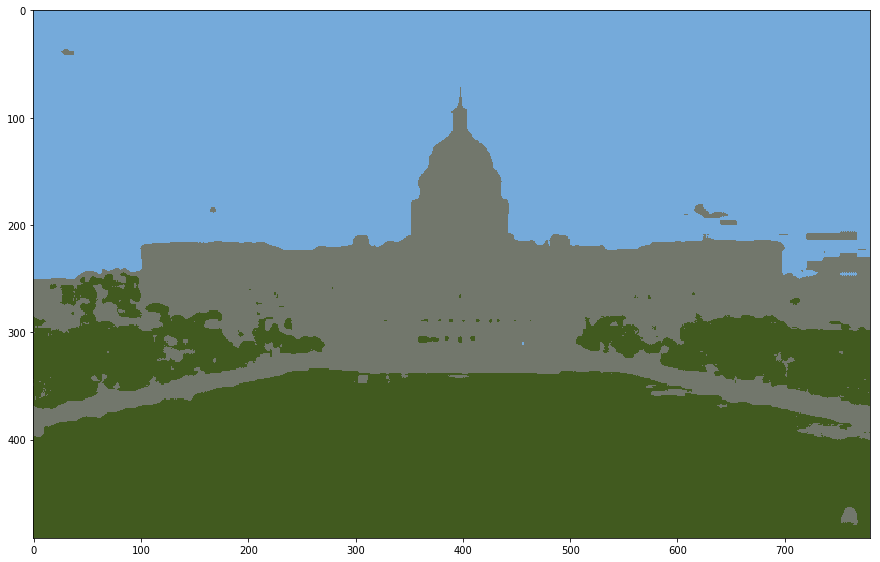

In [7]:
def reconstruct_img_from_lab(img_L, img_labels, cluster_centers):
    '''Reconstrói a imagem RGB a partir do resultado da segmentação k-médias. 
       Os parâmetros de entrada são o canal L da imagem no espaço Lab (img_L), 
       um array 2D contendo em cada posição o rótulo do pixel (img_labels) e 
       a cor, nos canais a e b, associada a cada rótulo (cluster_centers)'''

    img_reconst = np.zeros((img_L.shape[0], img_L.shape[1], 3))
    for label in range(num_clusters):
        ind = np.nonzero(img_labels==label)
        
        # Precisamos calcular um valor médio do canal L para associar 
        # a cada cluster
        avg_lightness = np.mean(img_L[ind[0],ind[1]])
        img_reconst[ind[0], ind[1], 0] = avg_lightness
        img_reconst[ind[0], ind[1], 1] = cluster_centers[label][0]
        img_reconst[ind[0], ind[1], 2] = cluster_centers[label][1]

    img_rgb = skimage.color.lab2rgb(img_reconst)

    return img_rgb

cluster_centers = km.cluster_centers_
img_rgb = reconstruct_img_from_lab(img_lab[:,:,0], img_labels, 
                                   cluster_centers)
    
plt.figure(figsize=[15,15])
plt.imshow(img_rgb)